In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import dataProcess

from datetime import datetime
import matplotlib.pyplot as plt
import optuna

In [77]:
def nan_to_above(data):
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      for k in range(data.shape[2]):
        if torch.isnan(data[i, j, k]):
          if j == 0:
            data[i, j, k] = 0
          else:
            data[i, j, k] = data[i, j-1, k]

In [76]:
# data preprocessing

# 2014-04-16
start = datetime(2014, 4, 16).date()
# 2024-04-11
end = datetime(2024, 4, 11).date()
hourly_path ='weatherstats_toronto_hourly.csv'
daily_path ='weatherstats_toronto_daily.csv'

# data
data_tensor_preprocess = dataProcess.dataToTensorHourly(hourly_path, separateByDay=False, missingThreshold=0.1, columnToDelete=['wind_dir', 'unixtime'], start=start, end=end)
data_tensor_preprocess_r = torch.flip(data_tensor_preprocess[0], dims=[0])


In [6]:
data = data_tensor_preprocess_r[:-7].reshape(-1, 24, 13)
nan_to_above(data)
print(data.shape)
print(data[0][0])
print(data[0][-1])

torch.Size([3648, 24, 13])
tensor([ 0.0000e+00,  1.0011e+02,  1.0228e+02,  3.0000e+01,  2.7000e+01,
         5.7000e+01, -1.2400e+01, -5.1000e+00,  2.4100e+04,  0.0000e+00,
        -4.9000e+00, -5.1000e+00,  1.0500e+02], dtype=torch.float64)
tensor([ 2.3000e+01,  1.0126e+02,  1.0344e+02,  1.5000e+01,  4.0000e+00,
         6.1000e+01, -6.3000e+00,  4.0000e-01,  2.4100e+04,  2.0000e+00,
         7.0000e-01,  4.0000e-01,  1.0500e+02], dtype=torch.float64)


In [9]:
# targets
targets_1 = dataProcess.dailyTargets(daily_path, start=datetime(2014, 4, 17).date())
targets = torch.flip(targets_1, dims=[0])
print(targets.shape)
print(targets[0])
print(targets[-1])

torch.Size([3648])
tensor(3.7500, dtype=torch.float64)
tensor(11.1500, dtype=torch.float64)


In [60]:
def process_data_for_rnn_gru(train_fraction, valid_fraction, data, targets, batch_size):

  train_dataset = TensorDataset(data, targets)
  total_size = len(data)
  train_split_point = int(total_size * train_fraction)
  valid_split_point = train_split_point + int(total_size * valid_fraction)

  train_dataset = TensorDataset(data[:train_split_point], targets[:train_split_point])
  val_dataset = TensorDataset(data[train_split_point:valid_split_point],
                              targets[train_split_point:valid_split_point])
  test_dataset = TensorDataset(data[valid_split_point:], targets[valid_split_point:])

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = process_data_for_rnn_gru(0.34, 0.33, data, targets, 2048)

In [78]:
class WeatherPredictorGRU(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.0):
    super(WeatherPredictorGRU, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, num_layers=num_layers, dropout=dropout_rate, batch_first=True)
    self.linear = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    out, _ = self.gru(x)
    last_hidden_state = out[:, -1, :]
    prediction = self.linear(last_hidden_state)
    return prediction

In [66]:
def train_model(trial, model, num_epochs, train_loader, val_loader, device):
  criterion = nn.MSELoss()
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

      model.eval()
      total_val_loss = 0
      with torch.no_grad():
        for inputs, targets in val_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          inputs, targets = inputs.float(), targets.float()
          outputs = model(inputs)
          loss = criterion(outputs, targets)
          total_val_loss += loss.item()

  avg_val_loss = total_val_loss / len(val_loader)
  return avg_val_loss

def objective(trial):
  input_size = 13
  hidden_size = trial.suggest_categorical('hidden_size', [16, 32, 64, 128, 256])
  output_size = 1
  num_layers = trial.suggest_int('num_layers', 1, 3)
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = WeatherPredictorGRU(input_size, hidden_size, output_size, num_layers, dropout_rate)
  model.to(device)

  num_epochs = 40
  return train_model(trial, model, num_epochs, train_loader, val_loader, device)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
  print(f"    {key}: {value}")

[I 2024-04-18 05:01:54,833] A new study created in memory with name: no-name-97e1bf93-7a54-4562-bd0e-1e9203b47419
<ipython-input-66-e0923c1c0354>:38: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.3)
<ipython-input-66-e0923c1c0354>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2024-04-18 05:01:56,101] Trial 0 finished with value: 119.24266052246094 and parameters: {'hidden_size': 32, 'num_layers': 2, 'dropout_rate': 0.2427131422637065, 'lr': 0.011255114338575166}. Best is trial 0 with value: 119.24266052246094.
/usr/local/lib/python3.10/dist-packages/torch/nn/module

Best trial:
  Value: 114.17523193359375
  Params: 
    hidden_size: 64
    num_layers: 2
    dropout_rate: 0.11606789348739228
    lr: 0.00257054046865064


Epoch [1/40], Training Loss: 213.8828, Validation Loss: 183.9213
Epoch [2/40], Training Loss: 204.9198, Validation Loss: 177.3788
Epoch [3/40], Training Loss: 197.4365, Validation Loss: 171.2157
Epoch [4/40], Training Loss: 190.1400, Validation Loss: 165.2830
Epoch [5/40], Training Loss: 183.2406, Validation Loss: 159.5606
Epoch [6/40], Training Loss: 176.4847, Validation Loss: 154.1766
Epoch [7/40], Training Loss: 169.9493, Validation Loss: 148.9594
Epoch [8/40], Training Loss: 163.5527, Validation Loss: 144.7822
Epoch [9/40], Training Loss: 158.3522, Validation Loss: 141.1972
Epoch [10/40], Training Loss: 153.8121, Validation Loss: 138.1446
Epoch [11/40], Training Loss: 149.8937, Validation Loss: 135.5282
Epoch [12/40], Training Loss: 146.5005, Validation Loss: 133.2179
Epoch [13/40], Training Loss: 143.4623, Validation Loss: 131.2962
Epoch [14/40], Training Loss: 140.9001, Validation Loss: 129.5914
Epoch [15/40], Training Loss: 138.6121, Validation Loss: 128.0513
Epoch [16/40], Trai

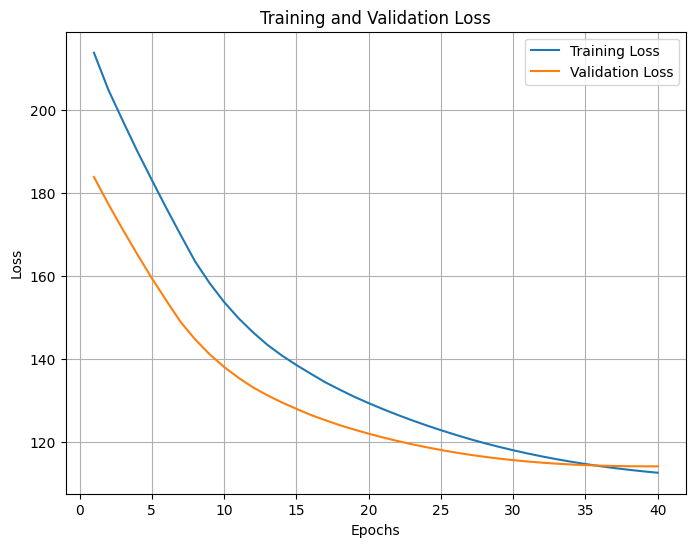

In [73]:
learning_rate = 0.0025705
num_epochs = 40
input_size = 13
hidden_size = 64
output_size = 1
num_layers = 2
dropout_rate = 0.11607

model = WeatherPredictorGRU(input_size, hidden_size, output_size, num_layers, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

def train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader):
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for inputs, targets in train_loader:
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()
      total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.float(), targets.float()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')

  # Plotting
  plt.figure(figsize=(8, 6))
  plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
  plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

train_model(model, num_epochs, optimizer, criterion, train_loader, val_loader)


In [74]:
def evaluate_model(model, criterion, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for inputs, targets in data_loader:
      inputs, targets = inputs.float(), targets.float()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      total_loss += loss.item()
  avg_loss = total_loss / len(data_loader)
  return avg_loss

test_loss = evaluate_model(model, criterion, test_loader)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 104.3072
